# Google Play Music and YouTube Music activity analysis

Grab your activity from https://takeout.google.com/

play_music.json - activity from Google Play Music

youtube.json - activity from YouTube Music

In [266]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import json
import pylast
from wordcloud import WordCloud
from textwrap import fill

In [265]:
my_activity = pd.DataFrame(columns=['artist', 'song', 'datetime', 'platform'])

with open('play_music.json') as file:
    input_data = json.load(file)
    for i in input_data:
        if i['title'].startswith('Listened to '):
            my_activity = my_activity.append({
                    'artist': i['description'].lower(), 
                    'song': i['title'].replace('Listened to ', '').lower(), 
                    'datetime': i['time'],
                    'platform': 'Play Music'},
                ignore_index=True)

with open('youtube.json') as file:
    input_data = json.load(file)
    for i in input_data:
        if (i['header'] == 'YouTube Music' and 
                i['title'].startswith('Watched ') and
                i['subtitles'][0]['name'].endswith(' - Topic')):
            my_activity = my_activity.append({
                    'artist': i['subtitles'][0]['name'].replace(' - Topic', '').lower(), 
                    'song': i['title'].replace('Watched ', '').lower(), 
                    'datetime': i['time'],
                    'platform': 'YouTube Music'},
                ignore_index=True)

In [140]:
my_activity['datetime'] = pd.to_datetime(my_activity.datetime)
my_activity['month_name'] = my_activity.datetime.dt.strftime('%b')
my_activity['weekday_name'] = my_activity.datetime.dt.strftime('%a')
my_activity['hour'] = my_activity.datetime.dt.hour
my_activity['month_year'] = my_activity.datetime.dt.year * 12 + my_activity.datetime.dt.month
my_activity['month_year_name'] = my_activity.datetime.dt.strftime('%b %Y')
my_activity['time'] = my_activity.datetime.dt.hour * 60 + my_activity.datetime.dt.minute

my_activity = my_activity.sort_values('datetime')

In [141]:
my_activity.head()

,artist,song,datetime,platform,month_name,weekday_name,hour,month_year_name,time,month_year
12684,alt-j,breezeblocks,2017-07-15 05:40:47.715000+00:00,Play Music,Jul,Sat,5,Jul 2017,340,24211
12683,alt-j,(guitar),2017-07-15 05:44:35.154000+00:00,Play Music,Jul,Sat,5,Jul 2017,344,24211
12682,скриптонит,на должном,2017-07-17 07:52:53.619000+00:00,Play Music,Jul,Mon,7,Jul 2017,472,24211
12681,скриптонит,сны,2017-07-17 07:53:01.007000+00:00,Play Music,Jul,Mon,7,Jul 2017,473,24211
12680,скриптонит,вниз,2017-07-17 07:53:11.411000+00:00,Play Music,Jul,Mon,7,Jul 2017,473,24211


### Period of activity

In [5]:
min_date = my_activity.datetime.min().strftime('%d.%m.%Y')
max_date = my_activity.datetime.max().strftime('%d.%m.%Y')
print(min_date + ' - ' + max_date)

15.07.2017 - 06.07.2019


### Count of listening

In [6]:
len(my_activity.index)

13972

### Count of songs

In [7]:
len(my_activity.groupby(['artist', 'song'], as_index=False).any().index)

4748

### Count of artists

In [726]:
my_activity.artist.nunique()

1015

### Proportion of listening by platform

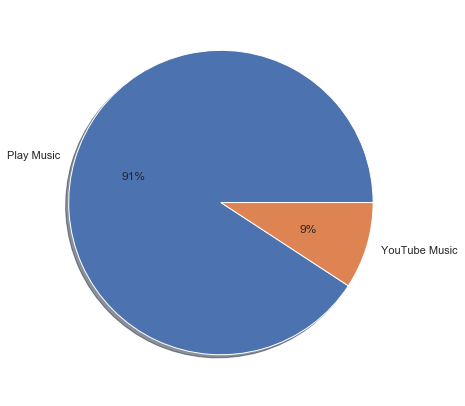

In [727]:
plt.figure(figsize=(7, 7))
data = my_activity.groupby('platform', as_index=False).agg({'datetime': 'count'})
plt.pie(x=data.datetime, labels=data.platform, autopct='%.0f%%', shadow=True)
plt.show()

### Bar chart of listening by month

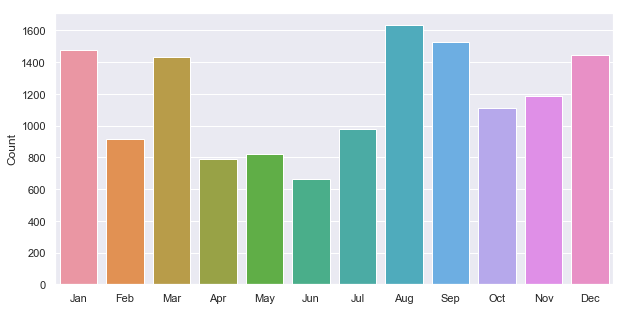

In [728]:
sns.set(rc={'figure.figsize':(10, 5)})
month_order = pd.date_range(pd.Timestamp('2019'), periods=12, freq='m').strftime('%b')
fig = sns.countplot(x='month_name', order=month_order, data=my_activity)
fig.set(xlabel='', ylabel='Count')
plt.show()

### Bar chart of listening by hour

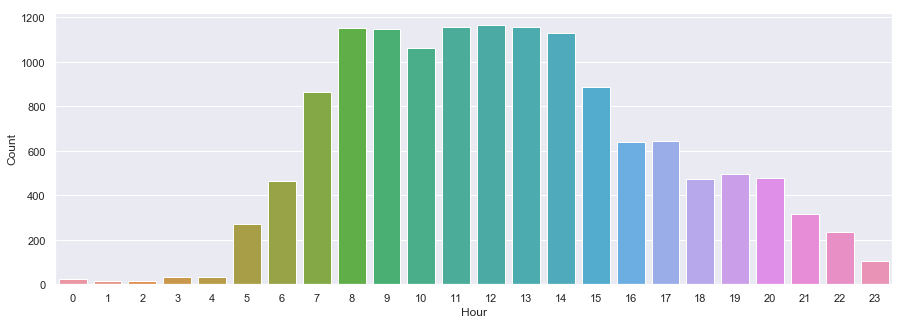

In [919]:
sns.set(rc={'figure.figsize':(15, 5)})
fig = sns.countplot(x='hour', data=my_activity)
fig.set(xlabel='Hour', ylabel='Count')
plt.show()

### Violin plot of listening by hour and day of week

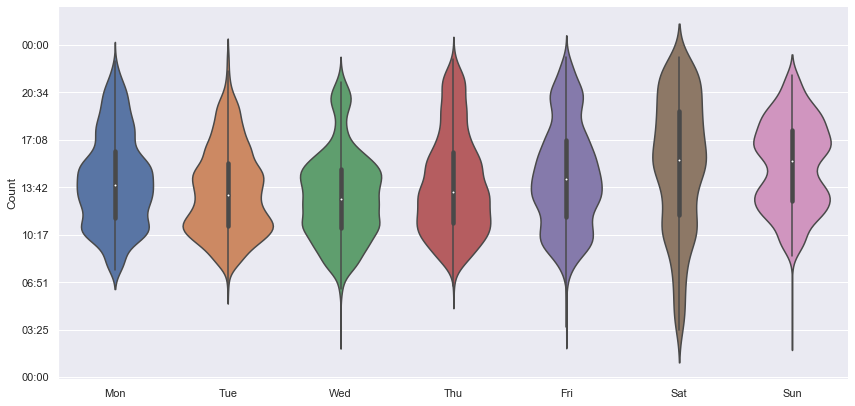

In [214]:
weekday_order = pd.date_range(pd.Timestamp('2019-01-07'), periods=7, freq='d').strftime('%a')
fig = sns.catplot(x="weekday_name", y="time", kind="violin", 
                  order=weekday_order, data=my_activity, height=6, 
                  aspect=2);
labels = [''] + pd.date_range('2019', periods=8, freq='205.715min').strftime('%H:%M').tolist()
fig.set(xlabel='', ylabel='Count', yticklabels=labels)
plt.show()

### Bar chart of listening by day of week

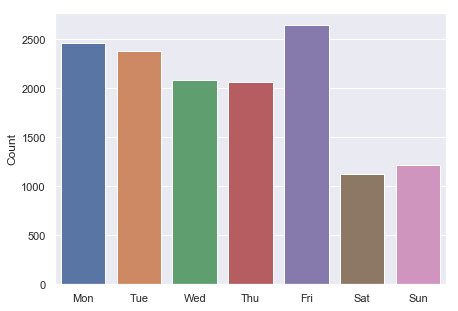

In [922]:
sns.set(rc={'figure.figsize':(7, 5)})
weekday_order = pd.date_range(pd.Timestamp('2019-01-07'), periods=7, freq='d').strftime('%a')
fig = sns.countplot(x='weekday_name',order=weekday_order, data=my_activity)
fig.set(xlabel='', ylabel='Count')
plt.show()

### Bar chart of listening by period

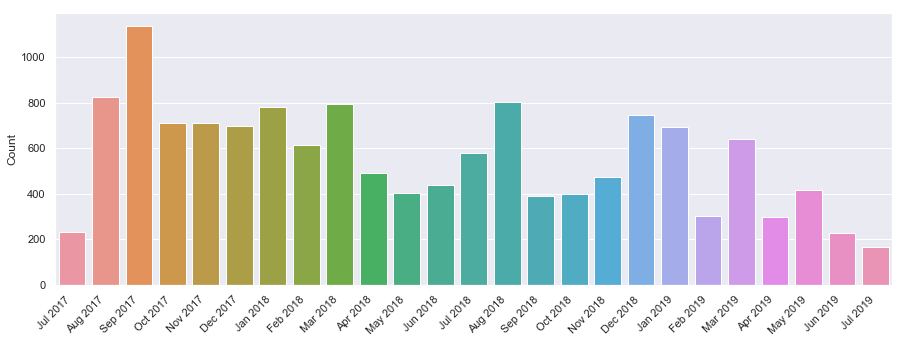

In [923]:
sns.set(rc={'figure.figsize':(15, 5)})
periods = my_activity.month_year_name.nunique()
period_order = pd.date_range(start, periods=periods, freq='m').strftime('%b %Y')
start = my_activity.datetime.min()
fig = sns.countplot(x='month_year_name', order=period_order, data=my_activity)
labels = fig.get_xticklabels()
fig.set_xticklabels(labels=labels, rotation=45, horizontalalignment='right')
fig.set(xlabel='', ylabel='Count')
plt.show()

### Top 10 Songs

In [924]:
top10_songs = my_activity. \
    groupby(['artist', 'song'], as_index=False). \
    aggregate({'datetime': 'count'}). \
    rename(columns={'datetime': 'count'}). \
    sort_values('count', ascending=False). \
    head(10)
top10_songs

,artist,song,count
689,eden,wrong,40
4313,скриптонит,животные,34
4289,синекдоха монток,ниточка в голове (),33
2042,pompeya,win,32
670,eden,crash,31
685,eden,take care,30
4270,свидание,я и твой кот,30
589,die antwoord,i fink u freeky,29
220,atl,танцуйте,29
4235,самое большое простое число,провал,29


### Top 10 Artist

In [8]:
top10_artists = my_activity. \
    groupby('artist', as_index=False). \
    agg({'datetime': 'count'}). \
    rename(columns={'datetime': 'count'}). \
    sort_values('count', ascending=False). \
    head(10)
top10_artists

,artist,count
949,скриптонит,418
930,пионерлагерь пыльная радуга,411
773,ария,317
173,eden,310
757,аигел,284
73,billie eilish,242
943,самое большое простое число,234
501,pompeya,229
647,the handsome family,211
944,свидание,209


### Distibution of listening of Top 10 Artist by period

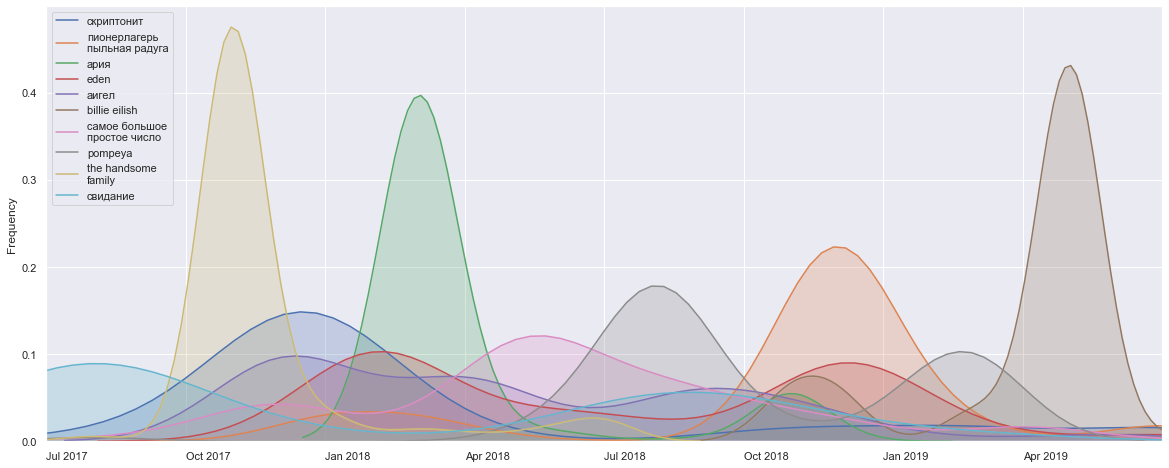

In [262]:
sns.set(rc={'figure.figsize':(20, 8)})
sns.set_palette(sns.color_palette(n_colors=10))
for i in list(top10_artists.artist):
    fig = sns.kdeplot(my_activity.loc[my_activity.artist == i]['month_year'], 
                      label=i, shade=True)
min_p, max_p = my_activity.month_year.min(), my_activity.month_year.max()
fig.set_xticks(np.arange(min_p, max_p, 3))
fig.set_xticklabels(my_activity.month_year_name.unique()[::3], 
                    horizontalalignment='left')
fig.set_ylabel('Frequency')

i, labels = fig.get_legend_handles_labels()
labels = [fill(l, 15) for l in labels]
fig.legend(i, labels)

plt.xlim(min_p, max_p)
plt.show()

### Artist cloud

In [120]:
artist_cloud = dict()

all_artists = my_activity. \
    groupby('artist', as_index=False). \
    agg({'datetime': 'count'}). \
    rename(columns={'datetime': 'count', 'artist': 'name'})
all_artists = all_artists.loc[all_artists['count'] > 1]

for i, i_artist in all_artists.iterrows():
    artist_cloud[i_artist[0]] = i_artist[1]

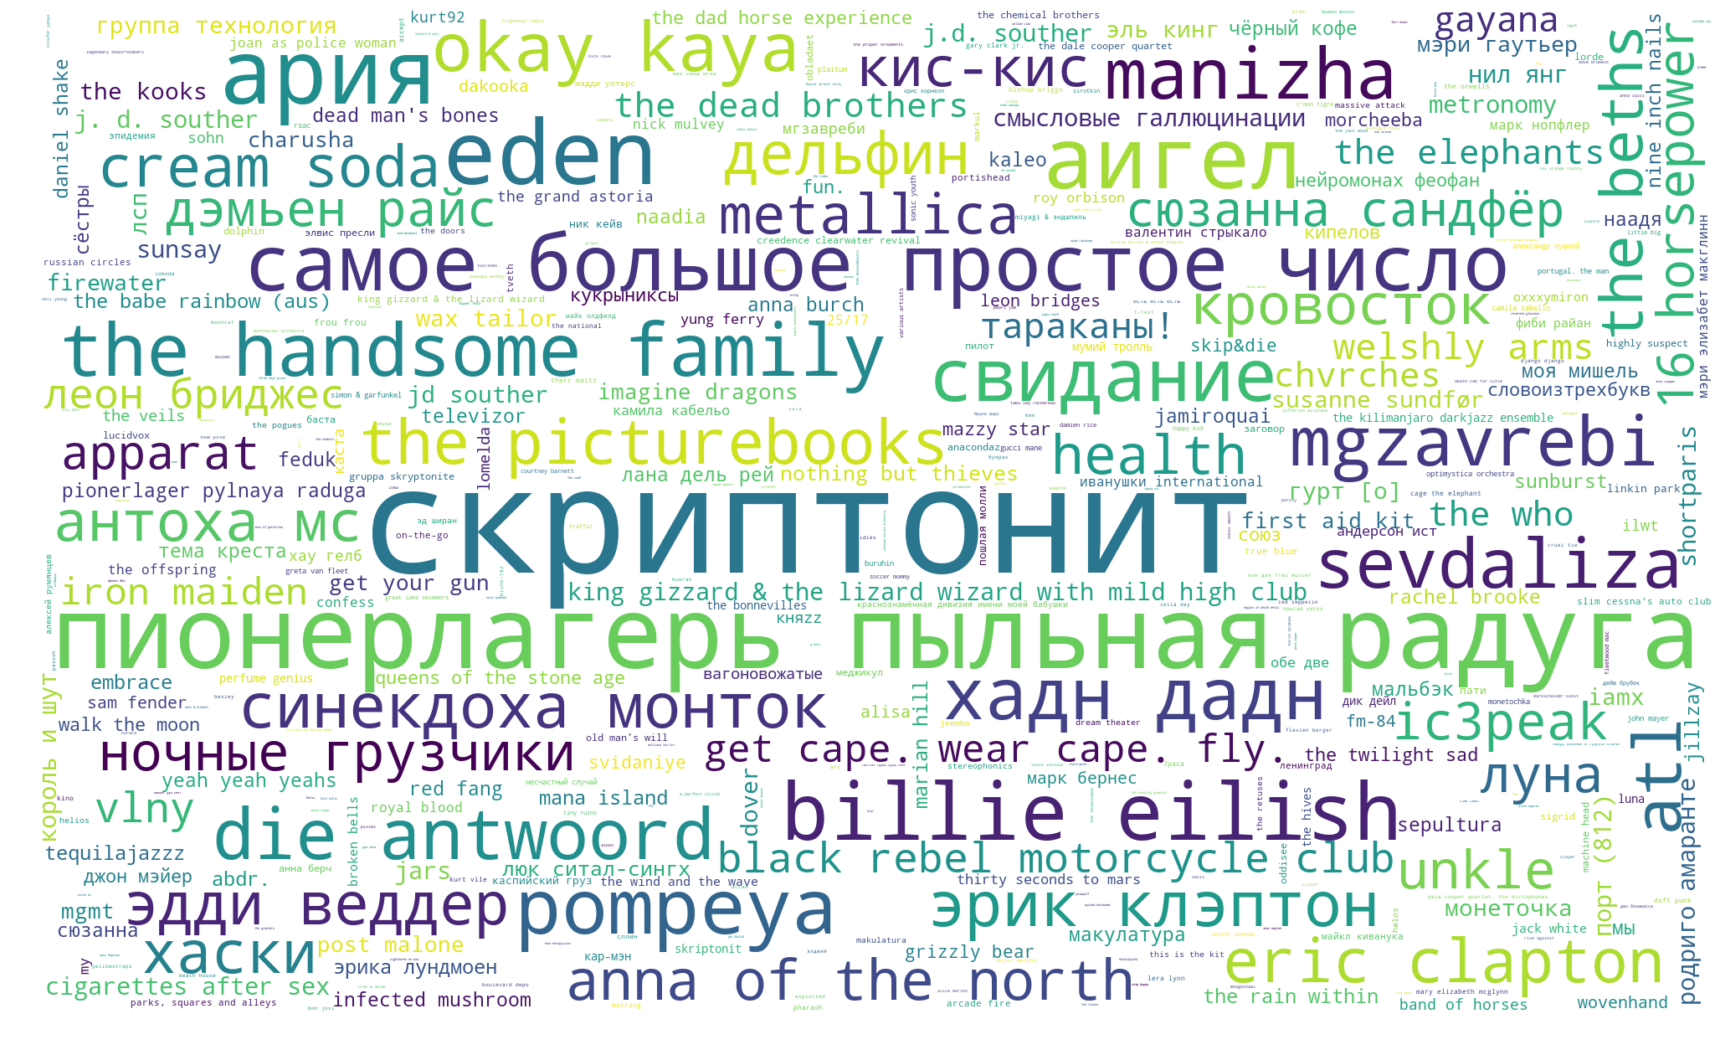

In [905]:
plt.figure(figsize=(30, 30))
wordcloud = WordCloud(background_color="white", 
                      max_words=len(artist_cloud), 
                      width=2000, height=1200). \
    generate_from_frequencies(artist_cloud)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Tag cloud from Last.fm

In [915]:
tag_cloud = dict()
API_KEY = "5f779cbcc9feb8326d787ab667df952a"
API_SECRET = "0478d752ecf25b5526935d7360c0b8cd"

all_artists = my_activity. \
    groupby('artist', as_index=False). \
    agg({'datetime': 'count'}). \
    rename(columns={'datetime': 'count', 'artist': 'name'})
all_artists = all_artists.loc[all_artists['count'] > 1]

network = pylast.LastFMNetwork(api_key=API_KEY, api_secret=API_SECRET)
for i, i_artist in all_artists.iterrows():
    artist = network.get_artist(i_artist[0])
    try:
        tags = artist.get_top_tags(limit=5)
    except pylast.WSError: continue
    for tag in tags:
        weight = float(tag.weight)
        if weight < 50: break
        tag_cloud[tag.item.name] = tag_cloud.setdefault(tag.item.name, 0)
        tag_cloud[tag.item.name] += weight * i_artist[1]

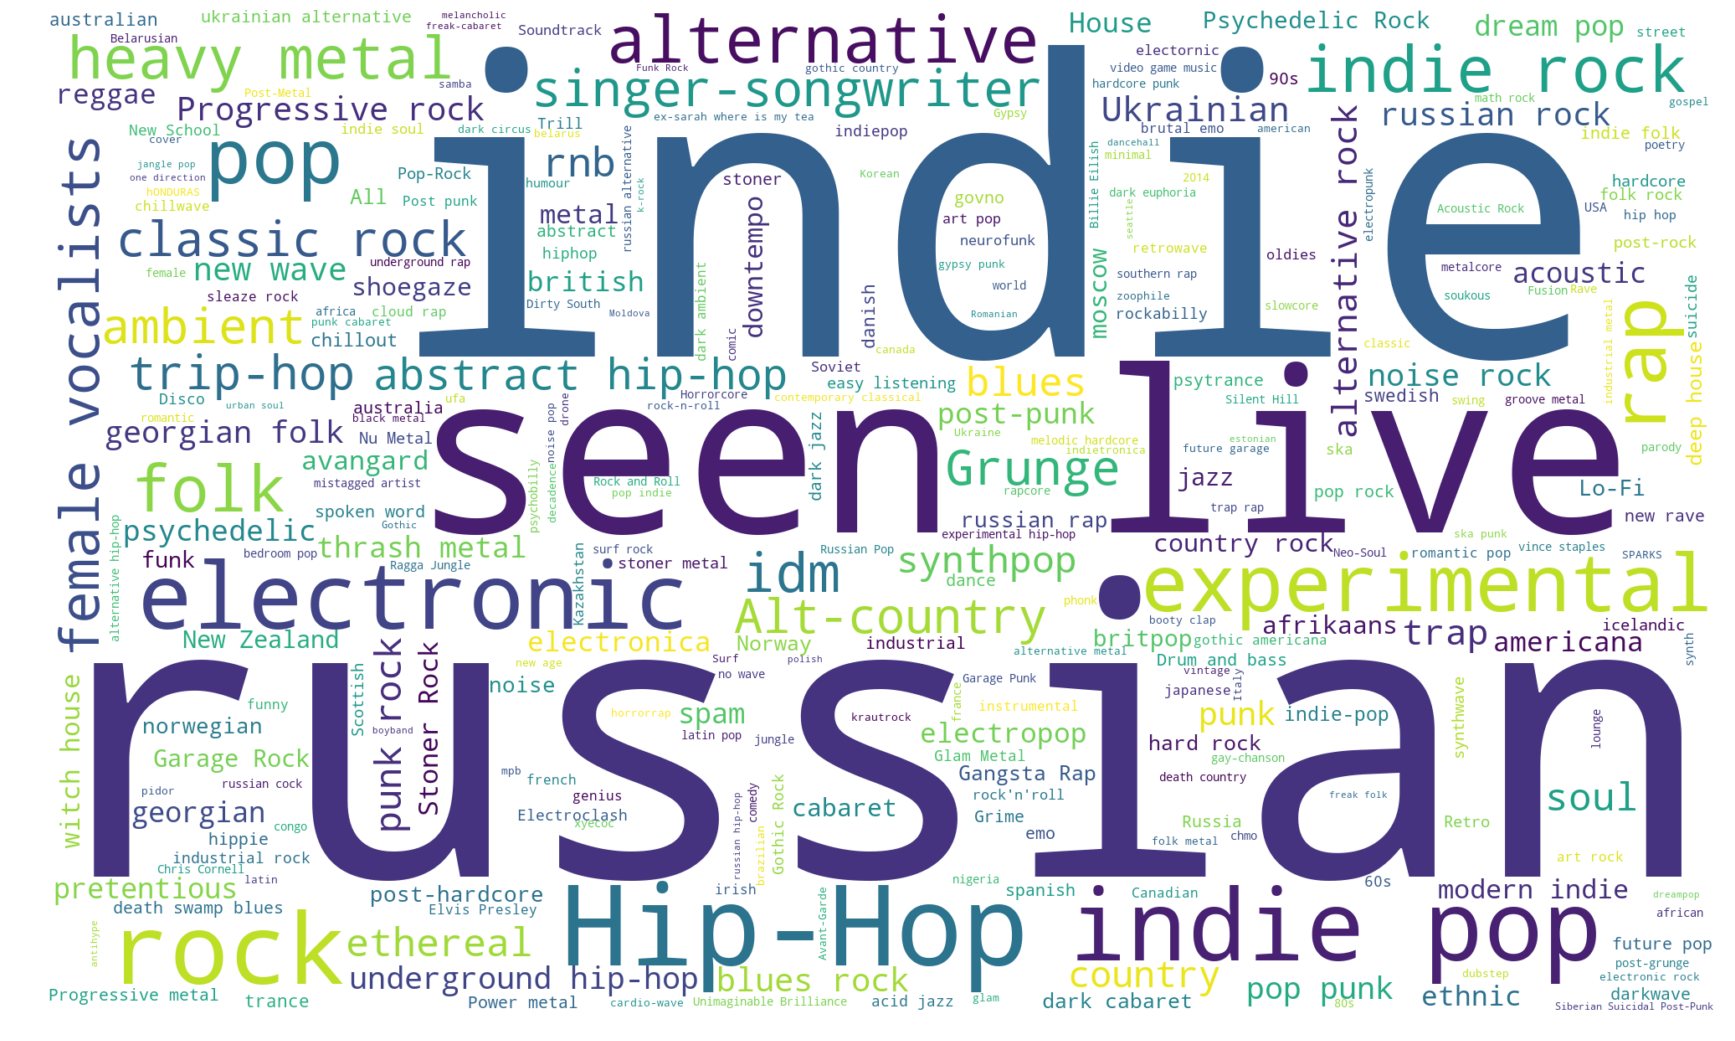

In [918]:
plt.figure(figsize=(30, 30))
wordcloud = WordCloud(background_color="white", 
                      max_words=len(tag_cloud),
                      width=2000, height=1200). \
    generate_from_frequencies(tag_cloud)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()